# Лабораторная №1. Настройка гиперпараметров и выбор алгоритма

**Выполнил**: Подцепко И. С. (учебная группа M3335).

## Набор данных

Для выполнения лабораторной работы был выбран набор данных, содержащий информацию о страничных блоках ([page-blocks](https://www.openml.org/search?type=data&status=active&id=1021)). Для удобства данные были переведены из формата ARFF в формат CSV.

Набор данных содержит 11 столбцов:

1. height (numeric)
2. lenght (numeric)
3. area (numeric)
4. eccen (numeric)
5. p_black (numeric)
6. p_and (numeric)
7. mean_tr (numeric)
8. blackpix (numeric)
9. blackand (numeric)
10. wb_trans (numeric)
11. binaryClass (P, или N) - целевой признак

Всего в наборе данных 5473 записей.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

from src.config import TARGET_COLUMN

Прочтем набор данных, сразу избавимся от колонки id, так как она появилась при конвертации ARFF в CSV и не несет полезной информации. А категориальный целевой признак `binaryClass` заменим признаком `class`, который уже будет числовым.

In [2]:
df = pd.read_csv('./data/raw/page-blocks.csv').drop(columns=['id'])
df[TARGET_COLUMN] = np.where(df.binaryClass == 'P', 0, 1)
df.drop(columns='binaryClass', inplace=True)
df.head(8)

,height,lenght,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans,class
0,5,7,35,1.400,0.400,0.657,2.33,14,23,6,0
1,6,7,42,1.167,0.429,0.881,3.60,18,37,5,0
2,6,18,108,3.000,0.287,0.741,4.43,31,80,7,0
3,5,7,35,1.400,0.371,0.743,4.33,13,26,3,0
4,6,3,18,0.500,0.500,0.944,2.25,9,17,4,0
5,5,8,40,1.600,0.550,1.000,2.44,22,40,9,0
6,6,4,24,0.667,0.417,0.708,2.50,10,17,4,0
7,5,6,30,1.200,0.333,0.333,10.00,10,10,1,0


Выделим тестовую часть (например, 30%). Набор данных не является временным рядом, так что можно перемешать записи.

In [3]:
from sklearn.model_selection import train_test_split

df, test = train_test_split(df, test_size=0.30, random_state=13, shuffle=True)
df.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
df.describe()

,height,lenght,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans,class
count,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000
mean,10.396241,90.588097,1229.136257,13.874618,0.369447,0.784745,6.811950,382.464631,760.850692,108.175411,0.104933
std,15.233693,115.655640,4985.250705,31.034051,0.178238,0.171706,82.155531,1400.934274,2026.867447,168.603027,0.306508
min,1.000000,1.000000,7.000000,0.009000,0.052000,0.062000,1.000000,7.000000,7.000000,1.000000,0.000000
25%,7.000000,17.000000,114.000000,2.167000,0.262000,0.677000,1.610000,42.000000,95.000000,17.000000,0.000000
50%,8.000000,41.000000,324.000000,5.125000,0.338000,0.805000,2.070000,109.000000,250.000000,48.000000,0.000000
75%,10.000000,108.500000,1001.000000,13.958500,0.426000,0.927000,3.030000,294.000000,744.000000,129.000000,0.000000
max,311.000000,552.000000,143993.000000,537.000000,1.000000,1.000000,4955.000000,33017.000000,46133.000000,3212.000000,1.000000


С целевым признаком из тестовой части я больше работать не буду, так что значения, которые мы будем предсказывать, уже можно сохранить в файл.

In [4]:
test[TARGET_COLUMN].to_csv('./data/answers.csv', index=False)
test.drop(columns=[TARGET_COLUMN], inplace=True)
test.head()

,height,lenght,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans
0,24,186,4464,7.750,0.505,0.989,7.40,2256,4413,305
1,12,383,4596,31.917,0.307,0.603,2.91,1409,2771,485
2,4,6,24,1.500,0.417,0.500,10.00,10,12,1
3,7,21,147,3.000,0.388,0.912,1.84,57,134,31
4,9,123,1107,13.667,0.395,0.991,2.84,437,1097,154


Также удобно выделить в отдельный data frame нецелевые признаки.

In [5]:
features = df.drop(columns=[TARGET_COLUMN])

Остальную часть набора данных подготовим для анализа. Во-первых, рассмотрим распределения признаков на гистограммах.

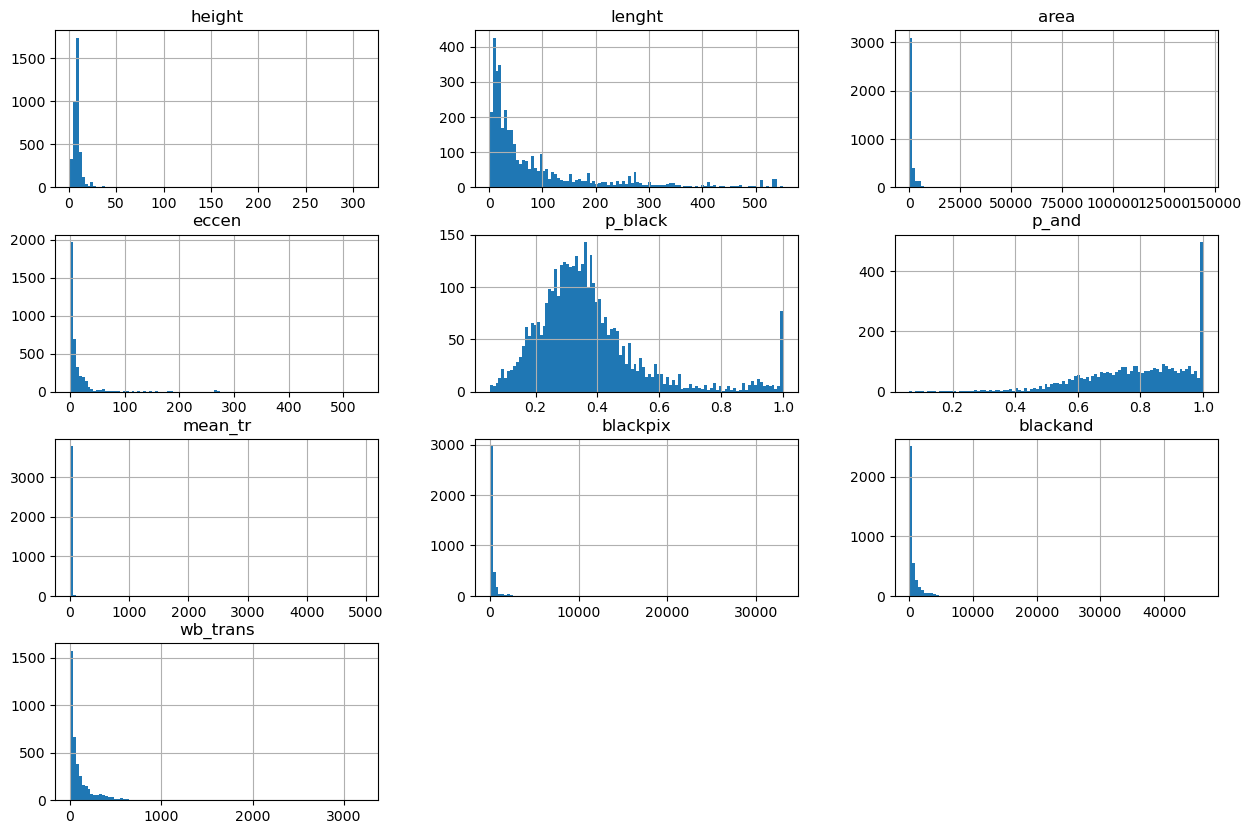

In [6]:
features.hist(figsize=(15, 10), bins=100);

Гистограммы показывают, что большинство признаков имеют распределение, похожее на нормальное, но не симметричное. У многих признаков есть "хвосты", которые могут оказаться выбросами (пусть и не критическими). Чтобы проверить данную гипотезу, рассмотрим boxplot'ы для признаков из набора данных.

3831


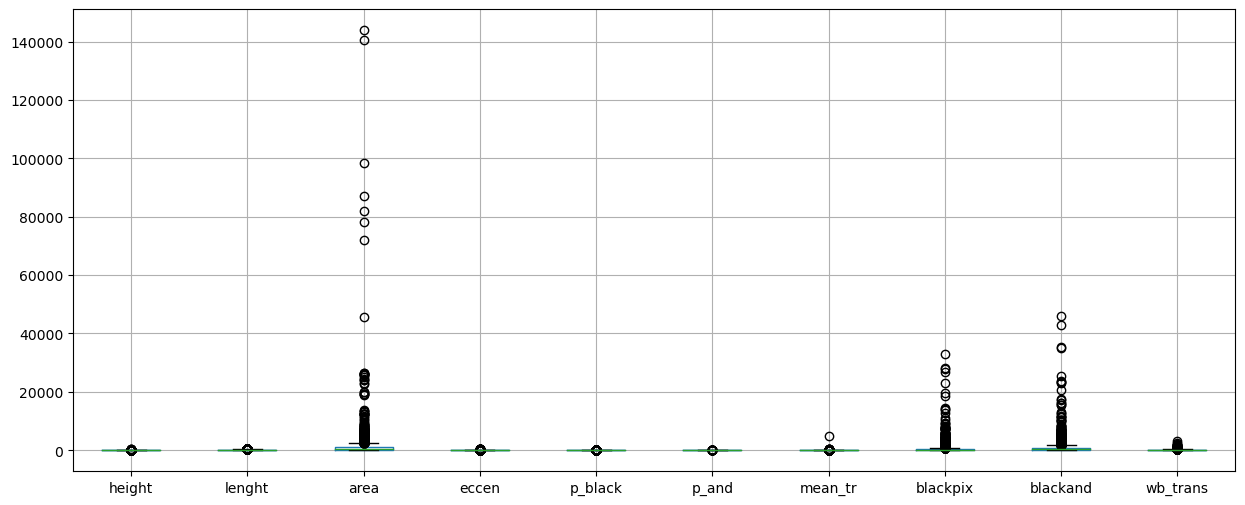

In [7]:
print(len(features))
features.boxplot(figsize=(15, 6));

Удалим записи с экстремальными выбросами (так как их не очень много).

3568


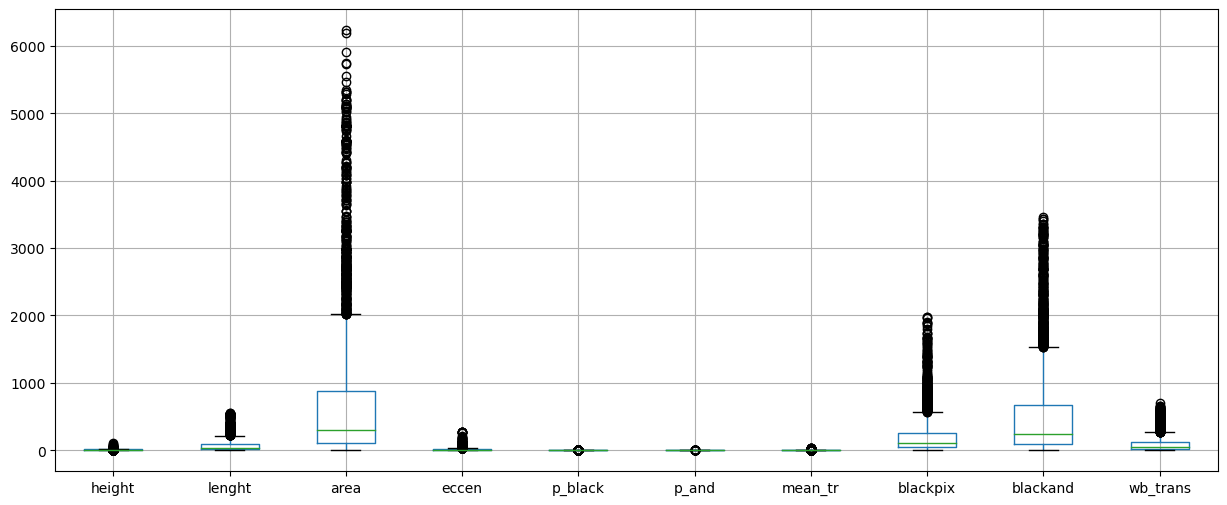

In [8]:
df.drop(df[(df.area > 7500) | (df.blackpix > 2000) | (df.blackand > 3500) | (df.mean_tr > 25)].index, inplace=True)
df.reset_index(drop=True, inplace=True)
features = df.drop(columns=[TARGET_COLUMN])

print(len(features))
features.boxplot(figsize=(15, 6));

Ящики с усами показывают наличие небольших выбросов у эксцесса и энтропии. Выполним нормализацию набора данных с помощью `sklearn.preprocessing.RobustScaller`, который выполняет центрирование по медиане (она лучше демонстрирует "среднего" представителя признака, нежели среднее арифметическое значение, а также менее чувствительна к выбросам), а масштабирование по величине межквартильного интервала (IQR).


In [9]:
from sklearn.preprocessing import RobustScaler

target = df[TARGET_COLUMN]

features_scaler = RobustScaler()
df = pd.DataFrame(features_scaler.fit_transform(features), columns=features.columns)

test = pd.DataFrame(features_scaler.transform(test), columns=test.columns)

df[TARGET_COLUMN] = target
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3568 entries, 0 to 3567
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   height    3568 non-null   float64
 1   lenght    3568 non-null   float64
 2   area      3568 non-null   float64
 3   eccen     3568 non-null   float64
 4   p_black   3568 non-null   float64
 5   p_and     3568 non-null   float64
 6   mean_tr   3568 non-null   float64
 7   blackpix  3568 non-null   float64
 8   blackand  3568 non-null   float64
 9   wb_trans  3568 non-null   float64
 10  class     3568 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 306.8 KB


В данном наборе данных нет пропусков и все признаки имеют числовой тип, так что на этом минимальная подготовка данных может быть окончена. Далее сохраним предобработанные данные для дальнейшего подбора алгоритма и гиперпараметров.

In [10]:
folder = Path('./data/preprocessed')
folder.mkdir(parents=True, exist_ok=True)

for dataset, file in (df, 'train.csv'), (test, 'test.csv'):
    dataset.to_csv(folder / file, index=False)